In [1]:
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import re

# Getting real estate listings


## Zumber

In [2]:
def Zumber(content): 
    soup = BeautifulSoup(content, "html.parser")
    PostalCode =  [x.text.replace(',', '').strip() for x in soup.find_all("span", class_="css-wmtwp4")]
    rent = [x.text for x in soup.find_all("div", class_="css-uzc059")]
    bed_bath = [x.text for x in soup.find_all("div", class_="css-1iq6kk8")]
    dateListed = [x.text for x in soup.find_all('div', 'css-174pdh3')]
    bed,bath = [x.split('•')[0] for x in bed_bath],  [x.split('•')[1] for x in bed_bath]


    dict = {'DateListed': dateListed, 'PostalCode':PostalCode,'Monthly': rent,  'Number of beds': bed, 'Number of baths': bath}
    df= pd.DataFrame(dict)
    df.loc[df['Monthly'].astype(str).str.contains('%'), 'Monthly'] = df['Monthly'].astype(str).str[:6]
    
    df['Monthly'] = df['Monthly'].apply(lambda x:x.replace('$','').replace(',','').replace("+",'').strip())
    df['Monthly']= df['Monthly'].replace({'K':'*1e3'}, regex=True).map(pd.eval)
    return df

### Studios

In [3]:
URL = "https://www.zumper.com/apartments-for-rent/vancouver-bc/west-end/studios"
requestURL = requests.get(URL)
content = requestURL.content

In [4]:
zumber0 = Zumber(content)

### 1 bed

In [5]:
URL2 = "https://www.zumper.com/apartments-for-rent/vancouver-bc/west-end/1-beds"
requestURL2 = requests.get(URL2)
content2 = requestURL2.content

In [6]:
zumber1= Zumber(content2)

## 2 Beds

In [7]:
URL3 = "https://www.zumper.com/apartments-for-rent/vancouver-bc/west-end/2-beds"
requestURL3 = requests.get(URL3)
content3 = requestURL3.content


In [8]:
zumber2 = Zumber(content3)

### 3 beds

In [9]:
URL4 = "https://www.zumper.com/apartments-for-rent/vancouver-bc/west-end/3-beds"
requestURL4 = requests.get(URL4)
content4 = requestURL4.content


In [10]:
zumber3 = Zumber(content4)

# Evaluation

In [11]:
mainZumberDF = pd.concat([zumber0, zumber1, zumber2, zumber3])

In [12]:
mainZumberDF

,DateListed,PostalCode,Monthly,Number of beds,Number of baths
0,1d ago,V6G 1P5,1900.0,Studio,1 Bath
1,10h ago,V6E 1H1,2700.0,Studio,1 Bath
2,1d ago,V6G 1G2,2500.0,Studio,1 Bath
3,1d ago,V6G 0C4,2095.0,Studio,1 Bath
4,1d ago,V6G 2A1,2200.0,Studio,1 Bath
...,...,...,...,...,...
19,5d+ ago,V6G 3H7,8500.0,3 Beds,2 Baths
20,5d+ ago,V6B 3E1,6700.0,3 Beds,3 Baths
21,9h ago,V6Z 1C3,8000.0,3 Beds,3 Baths
22,5d+ ago,V6G 3J6,5500.0,3 Beds,2 Baths


In [13]:
import seaborn as sns

<AxesSubplot: xlabel='Number of beds', ylabel='Monthly'>

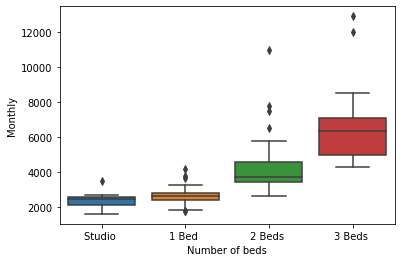

In [14]:
sns.boxplot(x='Number of beds', y='Monthly', data= mainZumberDF)

## Kijiji

In [39]:
def kijiji(content): 
    soup = BeautifulSoup(content, "lxml")
    realEstate = soup.findAll("div", class_="container-results large-images")[1]
    realEstate2 = [x.find('div', class_="info") for x in realEstate.findAll("div", attrs={"data-listing-id":True})]

    realEstateLinks = [x.find('div', class_=["title"]) for x in realEstate2]
    realEstateLinks1 = [x.find('a', attrs={"href":True}) for x in realEstate2]
    realEstateLinks = ["https://www.kijiji.ca"+ x['href'] for x in realEstateLinks1]

    dfKijiji = pd.DataFrame(columns=['DateListed','Postal Code','Monthly', 'Number of beds', 'Number of baths'])

    for i in range(len(realEstateLinks)):
        requestsIterate = requests.get(realEstateLinks[i])
        soup3 = BeautifulSoup(requestsIterate.text, "html.parser")


        for x in soup3.find_all('div', class_=['realEstateTitle-1440881021']):
            monthlyNum = x.find('span').text
            bedAndBath = [section.text for section in x.findAll('span', class_='noLabelValue-3861810455')]
            bedroomNum,bathroomNum = bedAndBath[1], bedAndBath[2]
            if x.find('time') is not None: 
                DateListed = x.find('time').text
            else:
                DateListed = ""
            if bool(re.match('V[0-9][A-Z] [0-9][A-Z][0-9]', x.find('span', class_="address-3617944557").text[-7:])):
                PostalCode = x.find('span', class_="address-3617944557").text[-7:]
            else:
                PostalCode = ""
            dfKijiji = dfKijiji.append({'DateListed':DateListed, 'Postal Code':PostalCode, 'Monthly': monthlyNum, 'Number of beds': bedroomNum,  'Number of baths': bathroomNum}, ignore_index=True)
    
    
    dfKijiji = dfKijiji.replace({'Number of beds': 'Bedrooms: Bachelor/Studio', 'Number of baths': 'Bathrooms: '}, 
    {'Number of beds': 'Studio', 'Number of baths': ''}, regex=True)

    dfKijiji['Number of baths'] = dfKijiji['Number of baths'] + " baths"

    dfKijiji['Monthly'] = dfKijiji['Monthly'].apply(lambda x:x.replace('$','').replace(',','').replace("+",'').strip())
    dfKijiji['Monthly']= dfKijiji['Monthly'].replace({'K':'*1e3'}, regex=True).map(pd.eval)
    
    return dfKijiji
    



### Studios

In [16]:
URL2 = "https://www.kijiji.ca/b-apartments-condos/vancouver-downtown-west-end/bachelor+studio/c37l1700292a27949001"
requestURL2 = requests.get(URL2)
content2 = requestURL2.content

In [56]:
kijijiStudios = kijiji(content2)

### 1 bedroom

In [18]:
URL2 = "https://www.kijiji.ca/b-apartments-condos/vancouver-downtown-west-end/1+bedroom/c37l1700292a27949001"
requestURL2 = requests.get(URL2)
contentOneBedRoom = requestURL2.content

In [57]:
kijijiOne = kijiji(contentOneBedRoom)

### 2 bed

In [29]:
URL2 = "https://www.kijiji.ca/b-apartments-condos/vancouver-downtown-west-end/2+bedrooms/c37l1700292a27949001"
requestURL2 = requests.get(URL2)
contentTwoBedRoom = requestURL2.content

In [58]:
kijijiTwo = kijiji(contentTwoBedRoom)

### 3 bed

In [122]:
URL2 = "https://www.kijiji.ca/b-apartments-condos/vancouver-downtown-west-end/3+bedrooms/c37l1700292a27949001"
requestURL2 = requests.get(URL2)
contentThreeBedRoom = requestURL2.content

In [123]:
kijijiThree = kijiji(contentThreeBedRoom)

In [124]:

mainKijiji = pd.concat([kijijiStudios, kijijiOne, kijijiTwo, kijijiThree])

<AxesSubplot: xlabel='Number of beds', ylabel='Monthly'>

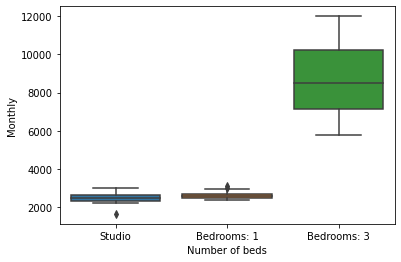

In [125]:
sns.boxplot(x='Number of beds', y='Monthly', data= mainKijiji)

## Pad Mapper

In [146]:
def padMapper(content): 
    #dict = {'DateListed': dateListed, 'PostalCode':PostalCode,'Monthly': rent,  'Number of beds': bed, 'Number of baths': bath}
    #df= pd.DataFrame(dict)
    soupPad = BeautifulSoup(content, "html.parser").find('body')

    rent = [x.text.strip() for x in soupPad.findAll("div", class_="ListItemMobile_text__3KFu_")]
    infoBubble= soupPad.findAll('script')[1].text
    linksInfo = ["https://www.padmapper.com/buildings/"+ x['href'].split("/")[2] for x in soupPad.findAll("a", class_='ListItemMobile_bubbleLink__fWhNX')]
    dateListedTotal, bedTotal, bathTotal,postalCodeTotal= [], [],[], []
    for i in range(len(linksInfo)):
        requestsIterate = requests.get(linksInfo[i])
        soup3 = BeautifulSoup(requestsIterate.text, "html.parser")
        if soup3.find('div', class_='Floorplan_title__2BJq9') is not None: 
            bedTotal.append(soup3.find('div', class_='Floorplan_title__2BJq9').text)
        else:
            bedTotal.append("")
        
        print(soup3.find("div",class_='Floorplan_pFloorplanFull__SIXh2'))
        
        # if soup3.find('span', class_='Floorplan_specLabel__2WIE2') is not None: 
        #     bathTotal.append(soup3.find('span', class_='Floorplan_specLabel__2WIE2').text)
        # else:
        #     bathTotal.append("")

        if soup3.find("meta", attrs={'name': "place:postal_code"}) is not None: 
            postalCodeTotal.append(soup3.find("meta", attrs={'name': "place:postal_code"})['content'])
        else:
            postalCodeTotal.append("")
        dateListedTotal.append("-")

    dateListed,bed,bath ="", "",""

    dict = {'DateListed': dateListed, 'PostalCode':postalCodeTotal,'Monthly': rent,  'Number of beds': bedTotal, 'Number of baths': bathTotal}
    df= pd.DataFrame(dict)

    df['Monthly'] = df['Monthly'].apply(lambda x:x.replace('$','').replace(',','').replace("+",'').strip())
    df['Monthly']= df['Monthly'].replace({'K':'*1e3'}, regex=True).map(pd.eval)
    return df

### Studio 

In [67]:
URL3 = "https://www.padmapper.com/apartments/vancouver-bc/west-end/studios"
requestURL3 = requests.get(URL3)
content3 = requestURL3.content

In [147]:
padMapper(content3)

<div class="Floorplan_pFloorplanFull__SIXh2"><div class="Floorplan_floorplansContainer__o-p9u"><div aria-expanded="false" class="Floorplan_floorplanPanel__3QVPS" role="button" tabindex="0"><div class="Floorplan_panelContent__1hNpz"><div class="Floorplan_title__2BJq9">Studios</div><div class="Floorplan_availabilityCount__1ssf1"><span>1</span> AVAILABLE</div><div class="Floorplan_priceRange__1f4P7">RENT <span>$1,900—$1,975</span></div></div><div class="Floorplan_panelToggleIcon__2J6w1"><span class="Floorplan_viewHide__35PG3">View</span></div></div></div><div class="Floorplan_floorplansContainer__o-p9u"><div aria-expanded="false" class="Floorplan_floorplanPanel__3QVPS" role="button" tabindex="0"><div class="Floorplan_panelContent__1hNpz"><div class="Floorplan_title__2BJq9">1 Bedrooms</div><div class="Floorplan_availabilityCount__1ssf1"><span>1</span> AVAILABLE</div><div class="Floorplan_priceRange__1f4P7">RENT <span>$2,450</span></div></div><div class="Floorplan_panelToggleIcon__2J6w1"><s

ValueError: All arrays must be of the same length

### 1 bathrooms

In [ ]:
URL4 = "https://www.padmapper.com/apartments/vancouver-bc/west-end/1-beds"
requestURL4 = requests.get(URL4)
content4 = requestURL4.content

padMapper(content4)

### 2 bathrooms

In [ ]:
URL4 = "https://www.padmapper.com/apartments/vancouver-bc/west-end/2-beds"
requestURL4 = requests.get(URL4)
content4 = requestURL4.content

padMapper(content4)

In [ ]:
URL4 = "https://www.padmapper.com/apartments/vancouver-bc/west-end/3-beds"
requestURL4 = requests.get(URL4)
content4 = requestURL4.content

padMapper(content4)

## Rent cafe

In [ ]:
import json



In [ ]:
def rentCafe(content): 
    soup3 = BeautifulSoup(content, "html.parser")
    realEstate = soup3.findAll(["li", "div"], class_=["listing-beds-rent data-rent-ask","data-rent"])
    rentInfo = [x.strip() for x in soup3.findAll("script", type="text/javascript")[4]]
    lastUpdated = [x.strip() for x in soup3.find("section")]
    rent = [x.text.strip() for x in realEstate]
    
    jsonData = json.loads(rentInfo[0][47:-3])
    baths, beds, PostalCode, area = [], [], [], []
    for i in range(len(jsonData)): 
        baths.append(jsonData[i]['Baths']), beds.append(jsonData[i]['Beds']), PostalCode.append(jsonData[i]['AddressFormatted'][-7:]), area.append(jsonData[i]["Area"])
    dict = {'PostalCode':PostalCode,'Monthly': rent,  'Number of beds': beds, 'Number of baths': baths, 'Area': area}
    df= pd.DataFrame(dict)
    df['Monthly'] = df['Monthly'].apply(lambda x:x.replace('$','').replace(',','').replace("+",'').strip())
    print(lastUpdated)
    print(jsonData)
    return df
   
    

In [ ]:
URLCafe1 = "https://www.rentcafe.com/studio-apartments-for-rent/ca/bc/vancouver/west-end-vancouver/"
requestURLCafe1 = requests.get(URLCafe1)
contentCafe1 = requestURLCafe1.content

rentCafe(contentCafe1)

TypeError: 'NoneType' object is not callable

In [ ]:
URLCafe1 = "https://www.rentcafe.com/1-bedroom-apartments-for-rent/ca/bc/vancouver/west-end-vancouver/"
requestURLCafe1 = requests.get(URLCafe1)
contentCafe1 = requestURLCafe1.content

rentCafe(contentCafe1)

,PostalCode,Monthly,Number of beds,Number of baths,Area
0,V6E 4S7,Ask for pricing,1 Bed,1 Bath,"371 - 1,291 Sq.Ft."
1,V6G 1X3,2350,1 Bed,1 Bath,450 - 500 Sq.Ft.
2,V6G 1X4,2175,1 Bed,1 Bath,450 - 650 Sq.Ft.
3,V6G 2L2,2950,1 Bed,1.5 Baths,"450 - 1,200 Sq.Ft."
4,V6G 3A3,Ask for pricing,1 Bed,1-1.5 Baths,465 - 950 Sq.Ft.
5,V6Z 0E7,2800,1 Bed,1 Bath,497 Sq.Ft.
6,V6G 2X3,Ask for pricing,1 Bed,1 Bath,"625 - 1,050 Sq.Ft."
7,V6B 0P4,2700,1 Bed,1 Bath,513 Sq.Ft.
8,V5L 2N1,2195,1 Bed,1 Bath,451 Sq.Ft.
9,V5N 1V9,2275,1 Bed,1 Bath,None


In [ ]:
URLCafe1 = "https://www.rentcafe.com/2-bedroom-apartments-for-rent/ca/bc/vancouver/west-end-vancouver/"
requestURLCafe1 = requests.get(URLCafe1)
contentCafe1 = requestURLCafe1.content

rentCafe(contentCafe1)

,PostalCode,Monthly,Number of beds,Number of baths,Area
0,V6E 4S7,3650,2 Beds,1-2 Baths,"371 - 1,291 Sq.Ft."
1,V6G 2L2,Ask for pricing,2 Beds,1.5 Baths,"450 - 1,200 Sq.Ft."
2,V6G 3A3,3050,2 Beds,1.5-2 Baths,465 - 950 Sq.Ft.
3,V6G 2X3,Ask for pricing,2 Beds,1-1.5 Baths,"625 - 1,050 Sq.Ft."
4,V6Z1W4,4500,2 Beds,2 Baths,814 Sq.Ft.
5,V6B 0E8,3800,2 Beds,2 Baths,"1,088 Sq.Ft."
6,V6A 0G3,2650,2 Beds,1 Bath,764 Sq.Ft.
7,V5N 1V9,3250,2 Beds,1-2 Baths,None
8,V5V 3E2,2800,2 Beds,1 Bath,800 Sq.Ft.
9,V7L 3J4,2950,2 Beds,1-2 Baths,"480 - 1,064 Sq.Ft."


In [ ]:
URLCafe1 = "https://www.rentcafe.com/3-bedroom-apartments-for-rent/ca/bc/vancouver/west-end-vancouver/"
requestURLCafe1 = requests.get(URLCafe1)
contentCafe1 = requestURLCafe1.content

rentCafe(contentCafe1)

,PostalCode,Monthly,Number of beds,Number of baths
0,V6G 0C7,6500,3 Beds,2 Baths
1,V6K 1K6,4200,3 Beds,2 Baths
2,V6R 2W5,12000,3 Beds,2.5 Baths
3,V5V 0B3,2850,3 Beds,2 Baths
4,V5N 1V9,4050,3 Beds,2 Baths
5,V7L 3J4,3700,3 Beds,2 Baths
